In [ ]:
#  Step 1: Install & Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score,  roc_curve, auc

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore")



In [ ]:
#  Step 2: Load Datasets

attack = pd.read_csv("CTU13_Attack_Traffic.csv")
normal = pd.read_csv("CTU13_Normal_Traffic.csv")

# Add labels
attack["Label"] = 1   # Botnet
normal["Label"] = 0   # Normal

# Combine
data = pd.concat([attack, normal], axis=0).sample(frac=1).reset_index(drop=True)

print("Final Dataset Shape:", data.shape)
print("\nClass Distribution:\n", data["Label"].value_counts())
data.head()


Final Dataset Shape: (92212, 58)

Class Distribution:
 Label
0    53314
1    38898
Name: count, dtype: int64


,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,...,Fwd Act Data Pkts,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,27996151,39,17,816,3980,72,0,20.923077,15.746987,280,...,30,546412.0,0.0,546412,546412,27449730.0,0.0,27449730,27449730,1
1,58764553,3,5,46,138,46,0,15.333333,26.558112,46,...,1,231742.0,0.0,231742,231742,58307574.0,0.0,58307574,58307574,0
2,53351,0,2,0,90,0,0,0.000000,0.000000,59,...,0,0.0,0.0,0,0,0.0,0.0,0,0,0
3,9011735,5,1,0,0,0,0,0.000000,0.000000,0,...,0,3003079.0,0.0,3003079,3003079,6008647.0,0.0,6008647,6008647,1
4,3781,1,2,0,0,0,0,0.000000,0.000000,0,...,0,0.0,0.0,0,0,0.0,0.0,0,0,0


In [ ]:
# 📌 Step 3: Preprocessing

# Drop non-numeric or irrelevant columns if any (e.g., timestamps, IPs)
non_numeric = [col for col in data.columns if data[col].dtype == "object"]
print("Dropping:", non_numeric)
data = data.drop(columns=non_numeric, errors="ignore")

# Split features & labels
X = data.drop("Label", axis=1)
y = data["Label"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Standardize features (important for Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)


Dropping: []
Train shape: (64548, 57)  Test shape: (27664, 57)


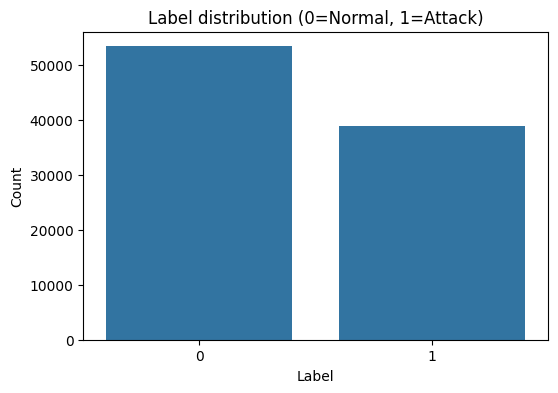

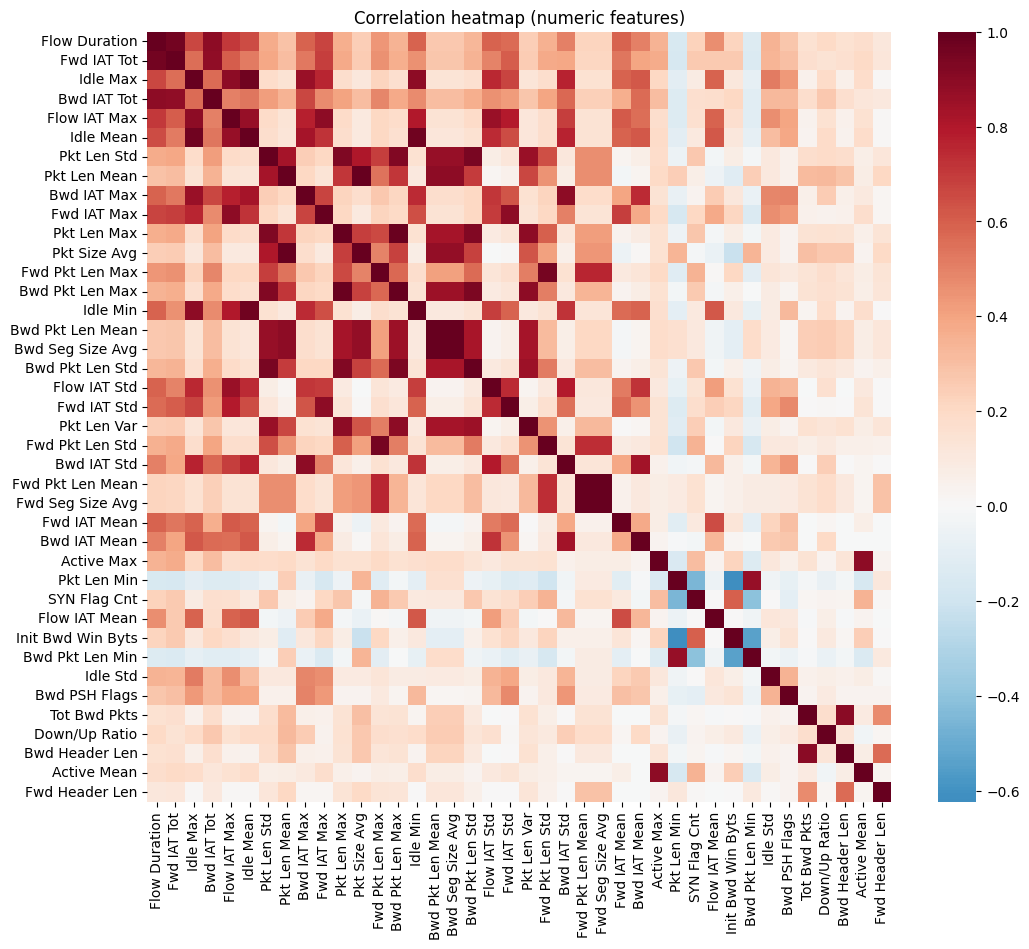

,label
label,1.000000
SYN Flag Cnt,0.399345
Fwd Pkts/s,0.321803
Flow Pkts/s,0.321553
Bwd Pkts/s,0.316281
Init Bwd Win Byts,0.272205
Active Min,0.233415
Active Mean,0.214834
Fwd Pkt Len Min,0.178055
Bwd IAT Tot,0.169444


In [ ]:
# 5) EDA
def plot_label_distribution(y):
    plt.figure(figsize=(6,4))
    sns.countplot(x=y)
    plt.title("Label distribution (0=Normal, 1=Attack)")
    plt.xlabel("Label")
    plt.ylabel("Count")
    plt.show()

def plot_corr_heatmap(X, top_n=30):
    corr = X.corr()
    # reduce heatmap size if too many features
    if corr.shape[0] > top_n:
        use_cols = corr.abs().sum().sort_values(ascending=False).head(top_n).index
        corr = corr.loc[use_cols, use_cols]
    plt.figure(figsize=(12,10))
    sns.heatmap(corr, cmap='RdBu_r', center=0, annot=False)
    plt.title("Correlation heatmap (numeric features)")
    plt.show()

def top_corr_with_label(X, y, top_k=20):
    df_tmp = pd.concat([X, y.rename('label')], axis=1)
    corrs = df_tmp.corr()['label'].abs().sort_values(ascending=False)
    return corrs.head(top_k)

if not X.empty:
    plot_label_distribution(y)
    plot_corr_heatmap(X, top_n=40)
    display(top_corr_with_label(X, y, top_k=20))


In [ ]:
# 6) Helper functions for evaluation and plotting
def plot_confusion(cm, labels=[0,1], title="Confusion Matrix"):
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

def print_classification(y_true, y_pred):
    print(classification_report(y_true, y_pred, digits=4))
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    print(f"Accuracy: {acc:.4f}  Precision: {prec:.4f}  Recall: {rec:.4f}  F1: {f1:.4f}")

def plot_roc_curve(y_true, y_score, label=None):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc:.3f})")
    return roc_auc


In [ ]:
#  Step 4: Train Multiple Models

models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.1,
                             subsample=0.8, colsample_bytree=0.8, eval_metric="logloss"),
    "LightGBM": LGBMClassifier(n_estimators=200, learning_rate=0.1, random_state=42)
}

results = {}

for name, model in models.items():
    if name == "Logistic Regression":
        model.fit(X_train_scaled, y_train)
        preds = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        preds = model.predict(X_test)

    acc = accuracy_score(y_test, preds)
    report = classification_report(y_test, preds, output_dict=True)
    results[name] = {
        "Accuracy": acc,
        "Precision": report["1"]["precision"],
        "Recall": report["1"]["recall"],
        "F1-Score": report["1"]["f1-score"]
    }
    print(f"\n✅ {name} Results:")
    print("Accuracy:", acc)
    print(classification_report(y_test, preds))



✅ Logistic Regression Results:
Accuracy: 0.9268724696356275
              precision    recall  f1-score   support

           0       0.92      0.95      0.94     15994
           1       0.93      0.89      0.91     11670

    accuracy                           0.93     27664
   macro avg       0.93      0.92      0.92     27664
weighted avg       0.93      0.93      0.93     27664


✅ Random Forest Results:
Accuracy: 0.9973973395026027
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15994
           1       1.00      1.00      1.00     11670

    accuracy                           1.00     27664
   macro avg       1.00      1.00      1.00     27664
weighted avg       1.00      1.00      1.00     27664


✅ XGBoost Results:
Accuracy: 0.9979395604395604
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15994
           1       1.00      1.00      1.00     11670

    accuracy     


📊 Model Comparison:

                     Accuracy  Precision    Recall  F1-Score
Logistic Regression  0.926872   0.932252  0.891431  0.911385
Random Forest        0.997397   0.996660  0.997172  0.996916
XGBoost              0.997940   0.998027  0.997087  0.997557
LightGBM             0.997795   0.997941  0.996829  0.997385


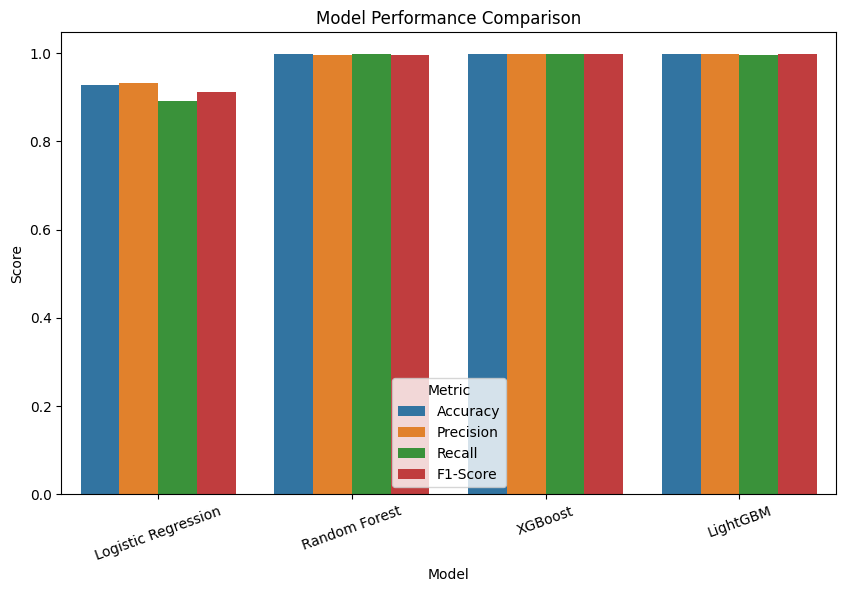

In [ ]:
#  Step 5: Compare Results in Table

results_df = pd.DataFrame(results).T
print("\n📊 Model Comparison:\n")
print(results_df)

plt.figure(figsize=(10,6))
sns.barplot(data=results_df.reset_index().melt(id_vars="index", var_name="Metric", value_name="Score"),
            x="index", y="Score", hue="Metric")
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xlabel("Model")
plt.xticks(rotation=20)
plt.show()


In [ ]:
sorted_result=results_df.sort_values(by='Accuracy',ascending=False)
display(sorted_result)

,Accuracy,Precision,Recall,F1-Score
XGBoost,0.997940,0.998027,0.997087,0.997557
LightGBM,0.997795,0.997941,0.996829,0.997385
Random Forest,0.997397,0.996660,0.997172,0.996916
Logistic Regression,0.926872,0.932252,0.891431,0.911385


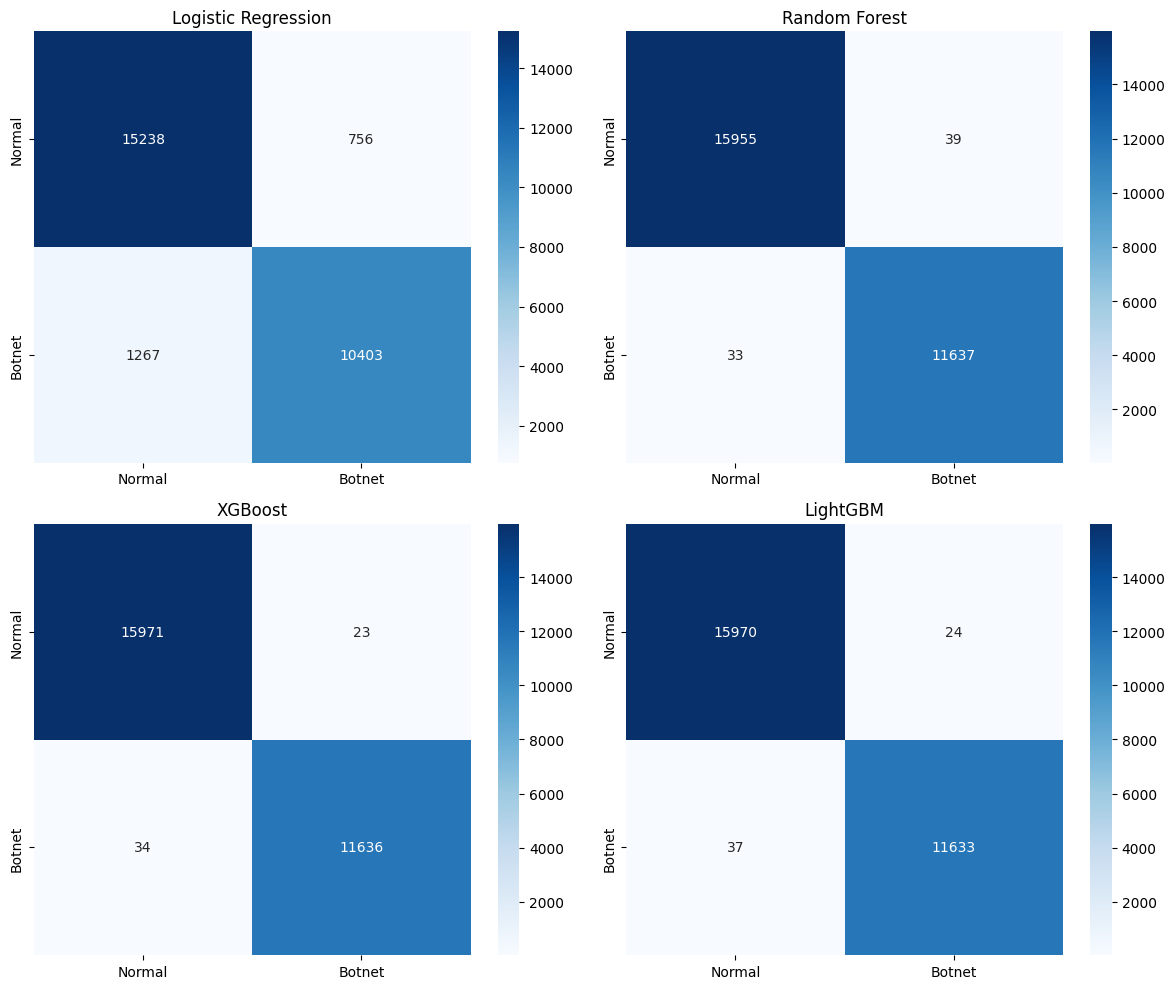

In [ ]:

#  Step 6: Confusion Matrices

fig, axes = plt.subplots(2, 2, figsize=(12,10))
axes = axes.flatten()

for ax, (name, model) in zip(axes, models.items()):
    if name == "Logistic Regression":
        preds = model.predict(X_test_scaled)
    else:
        preds = model.predict(X_test)
    cm = confusion_matrix(y_test, preds)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Normal","Botnet"], yticklabels=["Normal","Botnet"], ax=ax)
    ax.set_title(f"{name}")

plt.tight_layout()
plt.show()


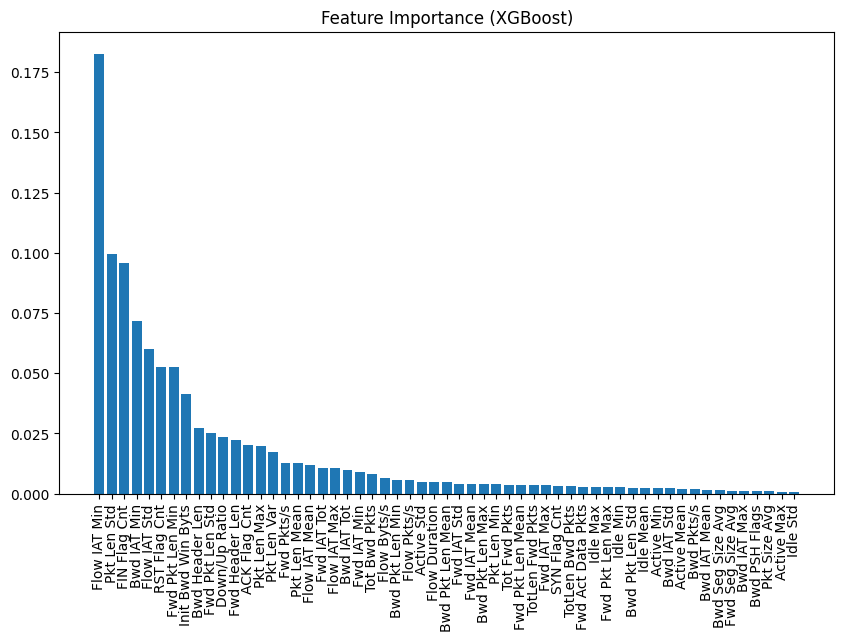

In [ ]:

# 📌 Step 7: Feature Importance (Best Model: XGBoost)

best_model = models["XGBoost"]

importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.title("Feature Importance (XGBoost)")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.show()


In [ ]:
#  Step 8: Save the Best Model + Scaler
import joblib

# Save model and scaler
joblib.dump(best_model, "best_botnet_model.pkl")
joblib.dump(scaler, "scaler.pkl")

print(" Best model saved as 'best_botnet_model.pkl'")
print(" Scaler saved as 'scaler.pkl'")

#  Step 9: Load Model and Test Prediction


# Load the saved model and scaler
loaded_model = joblib.load("best_botnet_model.pkl")
loaded_scaler = joblib.load("scaler.pkl")

# Take one sample from test set
sample = X_test.iloc[0].values.reshape(1, -1)


 Best model saved as 'best_botnet_model.pkl'
 Scaler saved as 'scaler.pkl'


In [ ]:
import joblib
import numpy as np
import re

# Step 1: Load the saved model and scaler
loaded_model = joblib.load("best_botnet_model.pkl")
loaded_scaler = joblib.load("scaler.pkl")

# Step 2: Define how many features your dataset has
num_features = 57

# Step 3: Ask user for input in one line
raw_input = input(f"Enter {num_features} feature values separated by commas:\n")

# Step 4: Convert input to list of floats, filtering out empty strings
try:
    # Split by comma, tab, or whitespace using regex
    user_input = [float(x) for x in re.split(r'[\s,]+', raw_input.strip()) if x]
except ValueError:
    print("Invalid input. Please ensure all values are numeric.")
    raise # Re-raise the exception for demonstration


# Check feature count
if len(user_input) != num_features:
    raise ValueError(f"⚠️ You must enter exactly {num_features} values! You entered {len(user_input)} values.") # Added count of entered values

# Step 5: Convert input to numpy array
new_data = np.array(user_input).reshape(1, -1)

# Step 6: Apply the saved scaler (only if the loaded model requires scaled data)
# As determined in the previous fix, the loaded best_model (XGBoost) does NOT require scaling.
# If you load Logistic Regression, you WOULD need to scale here.
# To be explicit, we'll apply the scaler to keep the option open, but note that
# for the current loaded model, it's not strictly necessary for prediction.
# However, applying the scaler doesn't hurt for tree-based models, they are scale-invariant.

# Applying scaler for consistency with original training of LR (if that model were loaded)
# and as a general preprocessing step.
new_data_scaled = loaded_scaler.transform(new_data)


# Step 7: Make prediction
# Use the scaled data for prediction with the loaded model.
# Even though XGBoost is scale-invariant, using scaled data here is fine
# and consistent if you were to switch to a scale-dependent model like LR.
prediction = loaded_model.predict(new_data_scaled) # Use scaled data
print("\n✅ Prediction:", prediction[0])

# Optional: Show probabilities
if hasattr(loaded_model, "predict_proba"):
    # Use scaled data for probability prediction as well
    probabilities = loaded_model.predict_proba(new_data_scaled)
    print("📊 Class probabilities:", probabilities)

Enter 57 feature values separated by commas:
22	1578	6872	670	0	98.625	210.6105015	1420	0	312.3636364	549.8859228	124.7112105	0.560831479	1831257.811	3801128.323	10024877	52	67711251	4514083.4	4918446.434	10025559	2722	67753648	3226364.19	4639388.152	10033007	52	0	320	456	0.23613957	0.324691909	0	1420	216.6666667	443.8639154	197015.1754	0	1	0	0	1	222.3684211	98.625	312.3636364	65535	10	85073.28571	144247.4849	300121	463	9525901.286	1205549.03	10024877	6798767	0	1.43E-06

✅ Prediction: 1
📊 Class probabilities: [[0.11868584 0.88131416]]
